In [1]:
import sys
sys.path.insert(0, '../src/')

from netgan.netgan import *
import tensorflow as tf
import torch
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from net.utils import *
import net.net as net
%matplotlib inline

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/holgerizor/anaconda3/envs/ne

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 128

In [7]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our Net model

In [8]:
netmodel = net.Net(N=_N,
                   H=10,
                   loss_fn=torch.nn.functional.cross_entropy,
                   loggers=[net.OverlapLogger(train_graph, print_every=10)])

#### Train our model

In [15]:
netmodel.train(generator=net_walker(walker),
               steps=100,
               optimizer_fn=torch.optim.Adam,
               optimizer_args={'lr': 0.01})

Step: 9, Loss: 3.16917, Edge-Overlap: 0.396
Step: 19, Loss: 3.26258, Edge-Overlap: 0.400
Step: 29, Loss: 3.10100, Edge-Overlap: 0.416
Step: 39, Loss: 3.10447, Edge-Overlap: 0.417
Step: 49, Loss: 3.17845, Edge-Overlap: 0.420
Step: 59, Loss: 2.86444, Edge-Overlap: 0.423
Step: 69, Loss: 2.94908, Edge-Overlap: 0.425
Step: 79, Loss: 3.06878, Edge-Overlap: 0.433
Step: 89, Loss: 3.01053, Edge-Overlap: 0.441
Step: 99, Loss: 2.94566, Edge-Overlap: 0.447


#### Evaluate our model

In [16]:
transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

In [17]:
scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                     symmetric=True,
                                                     mixing_coeff=.9)
scores_matrix = sp.csr_matrix(scores_matrix)

#### Evaluate generalization via link prediction

In [18]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [19]:
roc_auc_score(test_labels, test_scores)

0.936175

In [20]:
average_precision_score(test_labels, test_scores)

0.9451426132447244

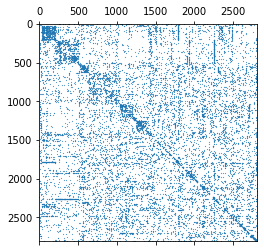

In [21]:
sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

In [22]:
sampled_graph.sum()

13566.0

In [23]:
utils.edge_overlap(train_graph.toarray(), sampled_graph)/train_graph.sum()

0.44390387734040987

In [24]:
utils.compute_graph_statistics(sampled_graph)

/home/holgerizor/anaconda3/envs/netgan/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 203.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2808,
 'wedge_count': 80187.0,
 'claw_count': 1889911.9999999998,
 'triangle_count': 1047,
 'square_count': 61,
 'power_law_exp': 1.803981271681866,
 'gini': 0.4319438957452244,
 'rel_edge_distr_entropy': 0.9535061146871354,
 'assortativity': -0.06927727314727672,
 'clustering_coefficient': 0.0016619821452004116,
 'n_components': 2,
 'cpl': 4.964370219046853}